# Manually choosing parameters, SARIMA(p,d,q)(P,D,Q)m

In [33]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sarimax import pre_process
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pmd
from sarimax import find_parameters
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings('ignore')

                      Total
Datetime                   
2023-07-15 17:00:00  1725.0
2023-07-15 18:00:00  1756.0
2023-07-15 19:00:00  1756.0
2023-07-15 20:00:00  1767.0
2023-07-15 21:00:00  1778.0


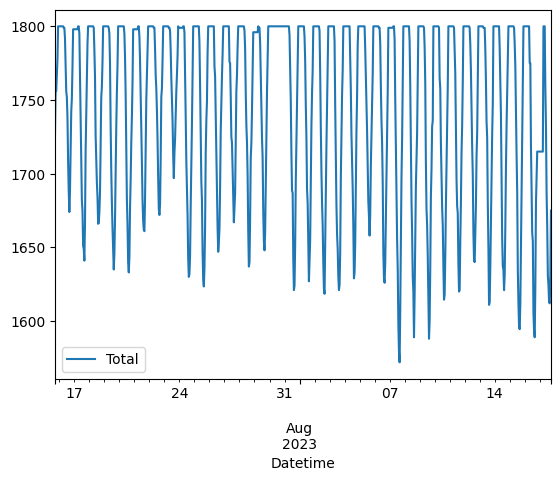

In [34]:
df = pre_process(csv_data_file_path='./Data/Bill_Bryson_Data.csv', resample_period='H')
# Constantly updating .csv, so conclusions may be relevant to the data
df = df[['Total']]
print(df.head())
df.plot()
plt.show()

In [35]:
# H0, data is not stationary
# H1, data is stationary
print(adfuller(df['Total'])[1]) # ADF is a unit root test that tests how much stationary in the time series
print(kpss(df['Total'])[1])
# adf: can't reject not stationary... pkss": reject stationary
# hence our data is not stationary.

ndiff = pmd.arima.ndiffs(df['Total'], test='adf')
print(f"Number of differencing recommended {ndiff} by pmdarima")

# Why is there an inconsistently with pmd.arima.ndiffs() and the ADF test?

0.12081584975430543
0.016225981006979473
Number of differencing recommended 0 by pmdarima


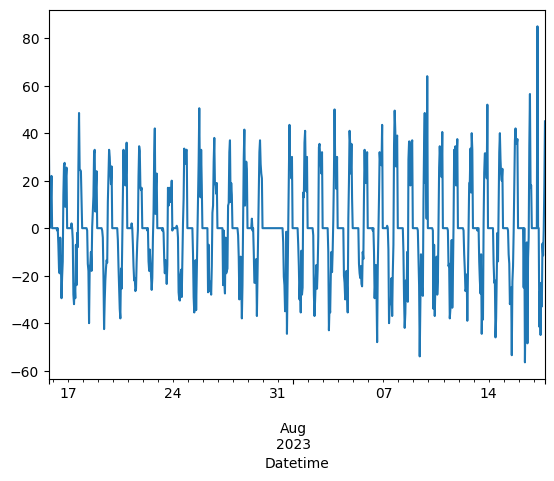

1.3233264520768448e-26


In [36]:
df_diff = df.diff().dropna()
df_diff['Total'].plot()
plt.show()
print(adfuller(df_diff['Total'])[1]) # Statistically significant

0


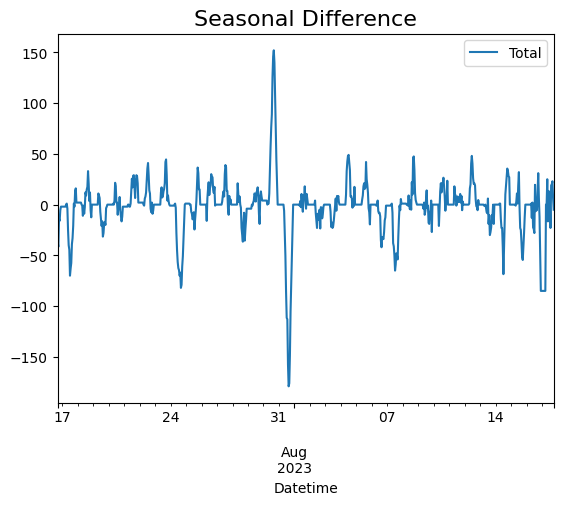

<Figure size 3000x600 with 0 Axes>

9.213806852980883e-15
0.1


In [37]:
print(pmd.arima.ndiffs(df, test='adf'))

df_diff_season = df.diff(24)
df_diff_season = df_diff_season.dropna()
df_diff_season.plot()
plt.title("Seasonal Difference", fontsize=16)
plt.figure(figsize=(30, 6))
plt.show()
print(adfuller(df_diff_season)[1])
print(kpss(df_diff_season)[1])
# Hence can determine that a differencing with a lag of m=24 will make our data stationary. So we have D = 1

In [ ]:

# Data does not have consistent variance seen through seasonal decompose and also comparing first and last half variance. Although not too extreme, may warrant a transformation such as boxcox.
transformed_values, lambda_value = boxcox(df['Total'])
original_values = inv_boxcox(transformed_values, lambda_value)

plt.figure(figsize=(10, 6))
plt.plot(df.index, transformed_values, label='Transformed')
plt.title('Box-Cox Transformation')
plt.legend()
plt.tight_layout()
plt.show()
print(adfuller(transformed_values)[1])
print(kpss(transformed_values)[1])
# Box-cox transformation makes
from sarimax import find_parameters
df1 = df[['Total', 'Weekend']]
df1.Total = transformed_values
find_parameters(df=df1, col='Total', cut_off=200, exog_var='Weekend')

With observation and exploration (seasonal_decomposition, acf and pacf plots), I believe I should difference both d=1 and D=1. However, the pmdarima functions ndiffs() and nsdiff() suggest I shouldn't. I will continue doing so, but check back once I have more data.

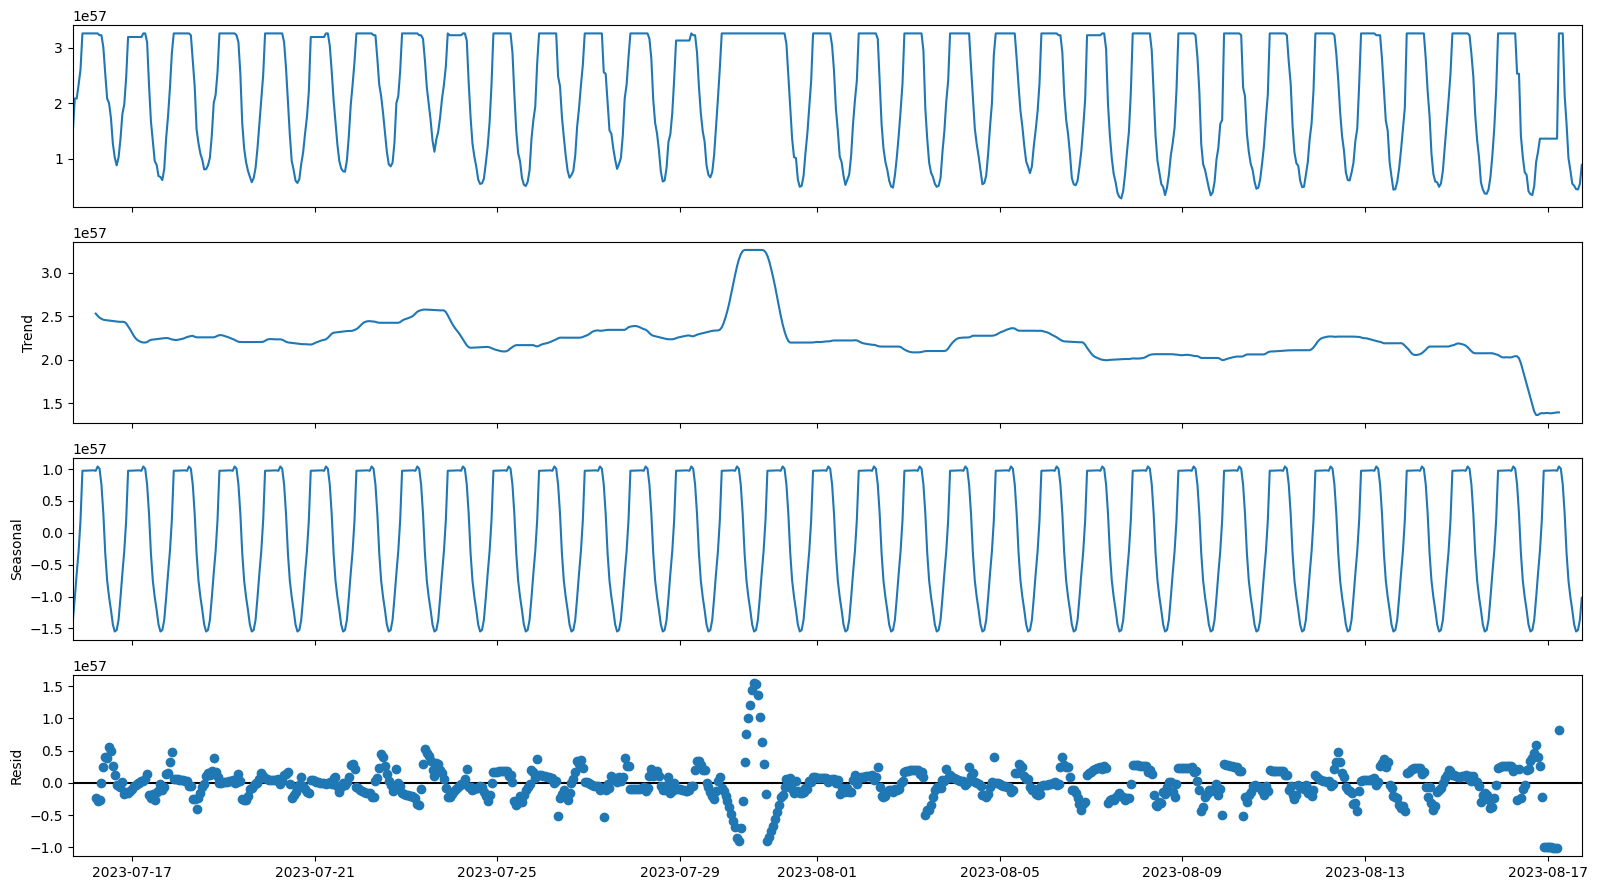

In [39]:
fig = seasonal_decompose(df).plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()


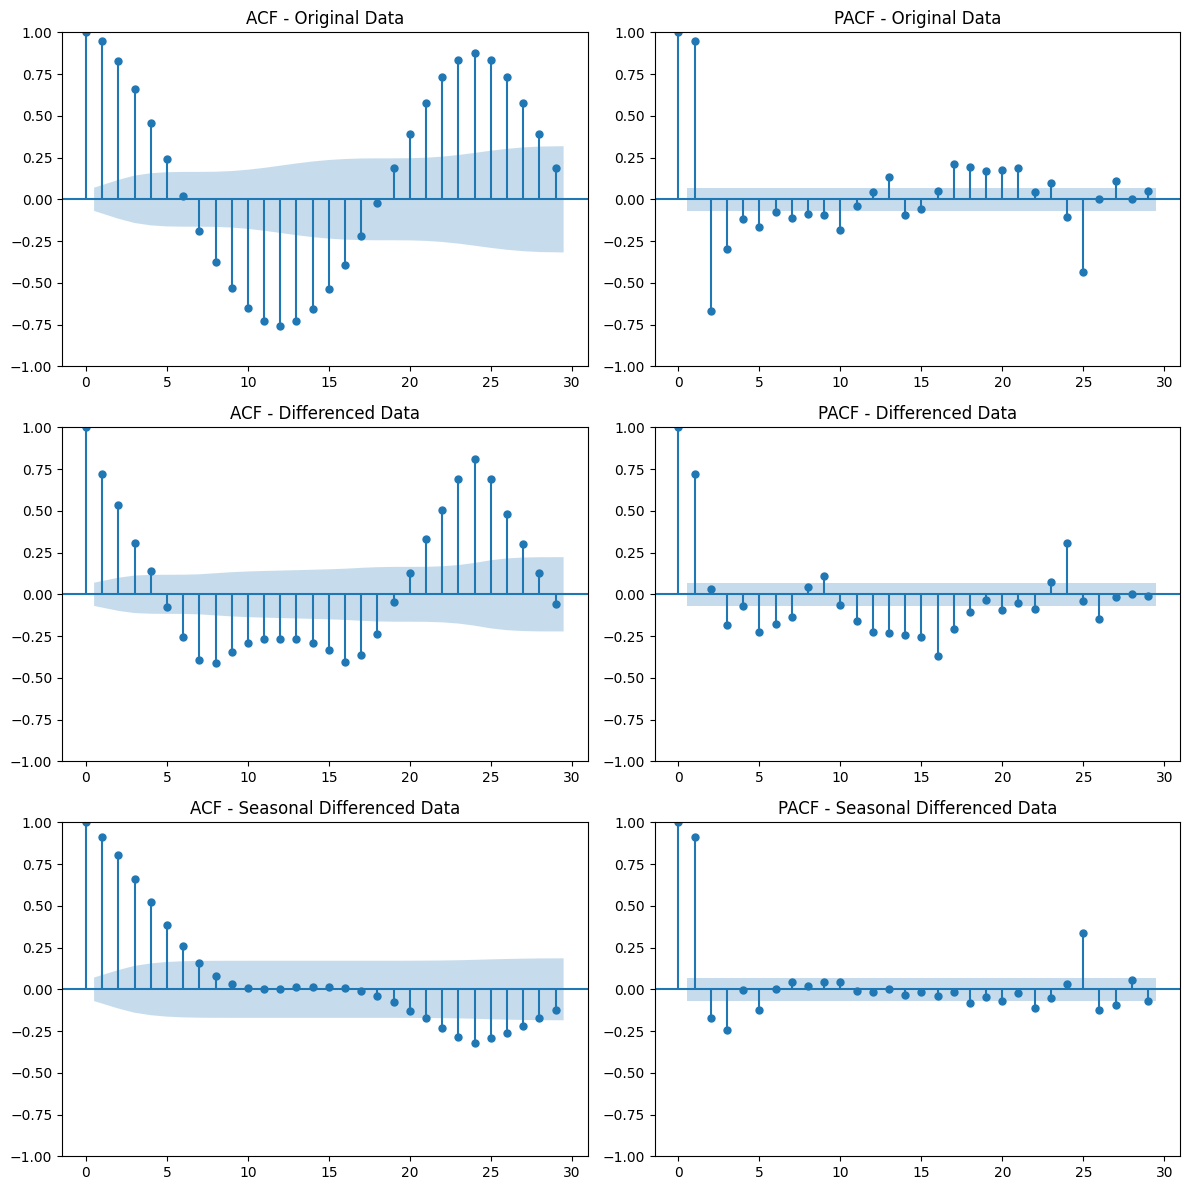

In [40]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

plot_acf(df, ax=axes[0, 0], title='ACF - Original Data')
plot_pacf(df, ax=axes[0, 1], title='PACF - Original Data')

plot_acf(df_diff, ax=axes[1, 0], title='ACF - Differenced Data')
plot_pacf(df_diff, ax=axes[1, 1], title='PACF - Differenced Data')

plot_acf(df_diff_season, ax=axes[2, 0], title='ACF - Seasonal Differenced Data')
plot_pacf(df_diff_season, ax=axes[2, 1], title='PACF - Seasonal Differenced Data')

plt.tight_layout()
plt.show()